# Main Code


In [1]:
import random
import sys
import timeit
import statistics
import matplotlib.pyplot as plt
import numpy as np

class Robot():
    
    def __init__(self):
        self.state  = 1
        self.reward = 0
        self.steps  = 0
    
    def reset(self):
        self.state  = 1
        self.reward = 0
        self.steps  = 0

class Enviorenment():
    
    def __init__(self): 
        self.seed = [] 
        self.matrix = np.zeros((100,4))
        self.penalty = 0              #Penalty for crashing against the wall
        self.alfa = 0.7
        self.discount = 0.99 
        self.walls1 = [17,27,37,47,57,67,77,87,97]
        self.walls2 = [4,14,24,34,44,54,64,74,84]
    
    #Gives reward to the robot
    def award(self,s):
        if(s == 100):
            return 100
        else:
            return 0 
        
    #Utility matrix update with max value possible        
    def updateMatrix(self, state0 , state1, action):
        self.matrix[state0 - 1][action] = (1 - self.alfa) * self.matrix[state0 - 1][action] + self.alfa *(self.award(state1)+self.discount*np.max(self.matrix[state1-1]))    

    #State transition 
    def states(self, state, action, pen):
        wallpen = 0
        temp = state
        if (action == 0):          #up
            if(state > 10):
                state-=10
            elif(pen == True):
                wallpen = self.penalty
        elif (action == 1):        #down
            if(state < 91):
                state+=10
            elif(pen == True):
                wallpen = self.penalty
        elif(action == 2):
            if( state % 10 != 1):  #left
                state -=1
            elif(pen == True):
                wallpen = self.penalty
        elif(action == 3):
            if( state % 10 != 0): #right
                state += 1
            elif(pen == True):
                wallpen = self.penalty
                
        if (state in self.walls1 or state in self.walls2) and pen == True :  #robot hit a wall
            state = temp
            wallpen = self.penalty
        return state, wallpen;
        
    #Break Ties of Matrix Q
    def tied(self,state):
        row = self.matrix[state-1]
        max_val = max(row)
        action = random.choice([i for i in range(len(row)) if row[i] == max_val]) 
        return action
        
    #Random walk state transition    
    def transitions(self, state, action,pen):
        state0 = state
        state1 , wallpen = self.states(state0,action,pen) 
        self.updateMatrix(state0,state1,action)
        return state1, wallpen;
    
    
    #Utility Matrix state transition
    def transitionsM(self,state,update,pen):  
        state0 = state
        action = self.tied(state)
        state1 , wallpen = self.states(state0,action,pen)                     
        if(update == True):
            self.updateMatrix(state0,state1,action)
        return state1, wallpen;            
        
class Game():
    def __init__(self):
        self.r = Robot()
        self.e = Enviorenment()
        self.steps = []
        self.values = [0, 1]
        self.prob = [0.7, 0.3] #second value is % of times the matrix is used 
             
    #Makes the robot move through the board        
    def walk(self,val,update,rand,pen):
        if(rand == True):
            temp = random.choices(self.values, self.prob)  #returns a list TEM DE TER O [0]
            val = temp[0]
        if(val == 0):    #random walk
            new_state, penalty = self.e.transitions(self.r.state,random.randint(0,3),pen)
        elif(val == 1 ):  #use matrix     
            new_state, penalty = self.e.transitionsM(self.r.state,update,pen)
        self.r.reward -= penalty    
        setattr( self.r , 'state',new_state)
        self.r.reward  += self.e.award(self.r.state)
        self.r.steps   += 1
        if(self.r.state == 100): #robot has reached the goal
            self.r.state = 1     
            self.steps.append(self.r.steps)
            self.r.steps = 0

# Ex1

Reward per Step stdev: 0.10148325268098497
Reward per Step mean: 0.17333333333333334
Runtime stdev: 0.0011653814584429325
Runtime mean: 0.00797259000000281
Steps to goal stdev: 219.21703107175668
Steps to goal mean: 343.8269230769231


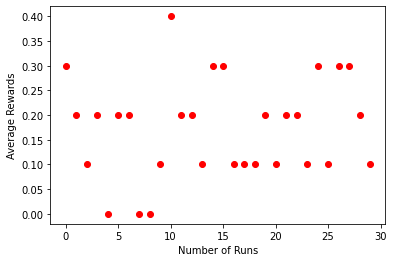

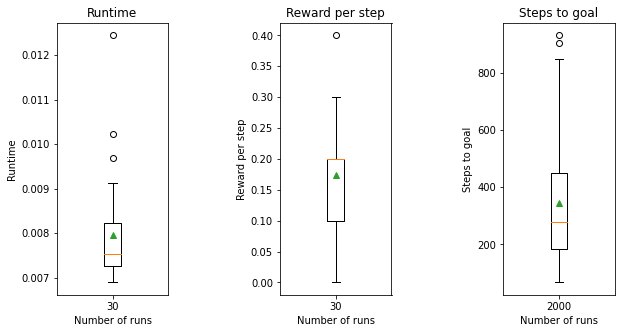

In [2]:
y = 0
x = 0
runs = 30
steps = 1000
random.seed(2)
runtime = []*runs
rewardperstep = []*runs
g = Game()

for x in range(0,runs):
    start = timeit.default_timer()
    for y in range(0,steps):
        g.walk(0,False,False,False)        
    stop = timeit.default_timer()
    runtime.append(stop-start)
    rewardperstep.append(g.r.reward/1000)
    g.r.reset()
    
#Showing Results
print("Reward per Step stdev:", statistics.stdev(rewardperstep))
print("Reward per Step mean:",statistics.mean(rewardperstep))
print("Runtime stdev:",statistics.stdev(runtime))
print("Runtime mean:",statistics.mean(runtime))
print("Steps to goal stdev:",statistics.stdev(g.steps))
print("Steps to goal mean:",statistics.mean(g.steps))

#Showing the baseline results with boxplots:
plt.plot(rewardperstep,'ro')
plt.xlabel('Number of Runs')
plt.ylabel('Average Rewards')

fig,(ax2,ax3,ax4) = plt.subplots(1,3,figsize =(10, 5))
ax2.boxplot(runtime, positions=[30],showmeans=True)
ax2.set_title('Runtime')
ax2.set_xlabel('Number of runs')
ax2.set_ylabel('Runtime')
ax3.boxplot(rewardperstep,positions=[30],showmeans=True)
ax3.set_title('Reward per step')
ax3.set_xlabel('Number of runs')
ax3.set_ylabel('Reward per step')
ax4.boxplot(g.steps,positions=[2000],showmeans=True)
ax4.set_title('Steps to goal')
ax4.set_xlabel('Number of runs')
ax4.set_ylabel('Steps to goal')
fig.subplots_adjust(wspace=1)

plt.show()

# EX 2a 


 The best sequence of actions corresponds to highests values possible(Q value) of a given line(state) and an column (action) of the matrix Q

Runtime stdev: 0.006277571405283847
Runtime mean: 0.2150807800000621


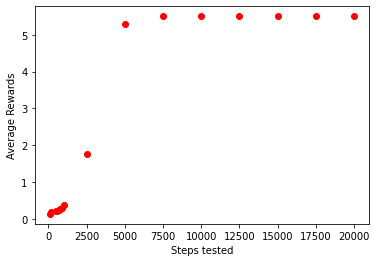

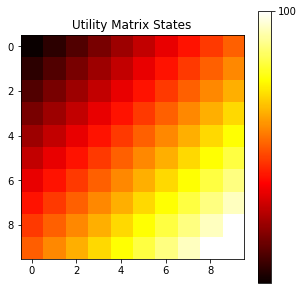

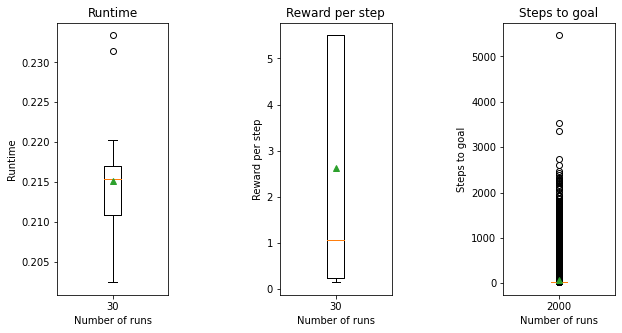

In [186]:
y = 0
x = 0
runs = 30
steps = 20000
random.seed(2)
runtime = []
reward = []
rewardmatrix = np.zeros((16,30))
matrixs = []
tests = [100, 200, 500, 600, 700, 800, 900, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]
g = Game()

for x in range(0,runs):
    start = timeit.default_timer()
    aux = 0
    g.e.matrix.fill(0)
    for y in range(0,steps):
        if y+1 in tests: #Running a test on the utility matrix and saving the current state
            stemp = g.r.state
            rtemp = g.r.reward
            sttemp = g.r.steps 
            g.r.reset()
            for z in range(0,999):
                g.walk(1,False,False,False)
            rewardmatrix[aux][x] = g.r.reward/1000
            aux +=1
            g.r.reward = rtemp
            g.r.steps  = sttemp
            g.r.state  = stemp
        else:
            g.walk(0,False,False,False)
    matrixs.append(g.e.matrix)
    g.r.reset()
    stop = timeit.default_timer()
    runtime.append(stop-start)
    
    
#Calculates the average reward per step for every test in all runs
rewardperstep = rewardmatrix.mean(1)

#Showing Results
print("Runtime stdev:",statistics.stdev(runtime))
print("Runtime mean:",statistics.mean(runtime))    

plt.plot(tests, rewardperstep, 'ro')
plt.xlabel('Steps tested')
plt.ylabel('Average Rewards')

#Heatmap geration
matrixfinal = np.mean(matrixs, axis=0)
matrixfinal[99]=100 
hmap = np.zeros((10,10))
count = 0
for a in range(10):
    for b in range(10):
        val = np.max(matrixfinal[count])
        hmap[a][b] = matrixfinal[count][np.argmax(matrixfinal[count])]
        count += 1
fig, ax = plt.subplots(figsize=(5,5))
img = ax.imshow(hmap,cmap ='hot')
cbar = fig.colorbar(img, ticks=[0, 100])
ax.set_title("Utility Matrix States")
   
fig2,(ax2,ax3,ax4) = plt.subplots(1,3,figsize =(10, 5))
ax2.boxplot(runtime, positions=[30],showmeans=True)
ax2.set_title('Runtime')
ax2.set_xlabel('Number of runs')
ax2.set_ylabel('Runtime')
ax3.boxplot(rewardperstep,positions=[30],showmeans=True)
ax3.set_title('Reward per step')
ax3.set_xlabel('Number of runs')
ax3.set_ylabel('Reward per step')
ax4.boxplot(g.steps,positions=[2000],showmeans=True)
ax4.set_title('Steps to goal')
ax4.set_xlabel('Number of runs')
ax4.set_ylabel('Steps to goal')
fig2.subplots_adjust(wspace=1)

plt.show()

# EX 2b 

After the using Q values of the Q table its possible to view that the robot took a more direct path to the reward over time therefore learning

Runtime stdev: 0.00957829558561857
Runtime mean: 0.26994300666641113


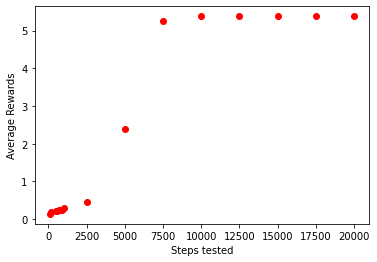

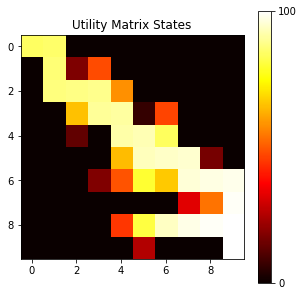

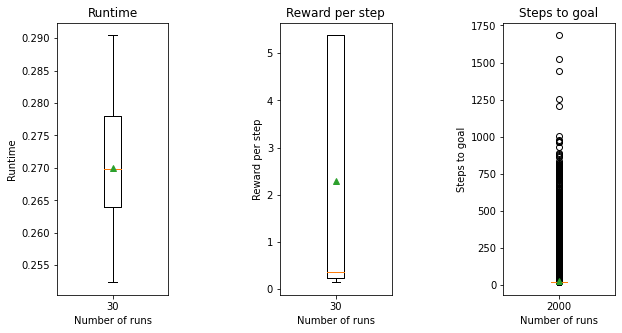

In [185]:
y = 0
x = 0
runs = 30
steps = 20000
random.seed(2)
runtime = []
rewardperstep = []
matrixs = []
rewardmatrix = np.zeros((16,30))
tests = [100, 200, 500, 600, 700, 800, 900, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]
g = Game()

for x in range(0,runs):
    start = timeit.default_timer()
    aux = 0
    g.e.matrix.fill(0)
    for y in range(steps):
        if y+1 in tests: #Running a test on the utility matrix and saving the current state
            stemp = g.r.state
            rtemp = g.r.reward
            sttemp = g.r.steps 
            g.r.reset()
            for z in range(0,999):
                g.walk(1,False,False,False)
            rewardmatrix[aux][x] = g.r.reward/1000
            aux +=1
            g.r.reward = rtemp
            g.r.steps  = sttemp
            g.r.state  = stemp
        else:
            g.walk(1,True,False,False)
    g.r.reset()
    matrixs.append(g.e.matrix)
    stop = timeit.default_timer()
    runtime.append(stop-start)

rewardperstep = rewardmatrix.mean(1)

#Showing Results   
print("Runtime stdev:",statistics.stdev(runtime))
print("Runtime mean:",statistics.mean(runtime))      

plt.plot(tests, rewardperstep,'ro')
plt.xlabel('Steps tested')
plt.ylabel('Average Rewards')

#Heatmap Geration
matrixfinal = np.mean(matrixs, axis=0)
matrixfinal[99]=100 
hmap = np.zeros((10,10))
count = 0
for a in range(10):
    for b in range(10):
        val = np.max(matrixfinal[count])
        hmap[a][b] = matrixfinal[count][np.argmax(matrixfinal[count])]
        count += 1
fig2, ax = plt.subplots(figsize=(5,5))
img = ax.imshow(hmap,cmap ='hot')
cbar = fig2.colorbar(img, ticks=[0, 100])
ax.set_title("Utility Matrix States")

fig,(ax2,ax3,ax4) = plt.subplots(1,3,figsize =(10, 5))
ax2.boxplot(runtime, positions=[30],showmeans=True)
ax2.set_title('Runtime')
ax2.set_xlabel('Number of runs')
ax2.set_ylabel('Runtime')
ax3.boxplot(rewardperstep,positions=[30],showmeans=True)
ax3.set_title('Reward per step')
ax3.set_xlabel('Number of runs')
ax3.set_ylabel('Reward per step')
ax4.boxplot(g.steps,positions=[2000],showmeans=True)
ax4.set_title('Steps to goal')
ax4.set_xlabel('Number of runs')
ax4.set_ylabel('Steps to goal')
fig.subplots_adjust(wspace=1)

plt.show()

# EX 3 - Greed at 0.3



Runtime stdev: 0.010423354382623687
Runtime mean: 0.3666740699998627


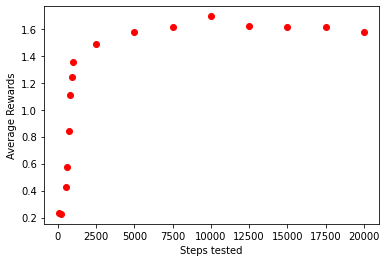

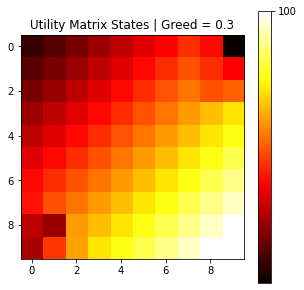

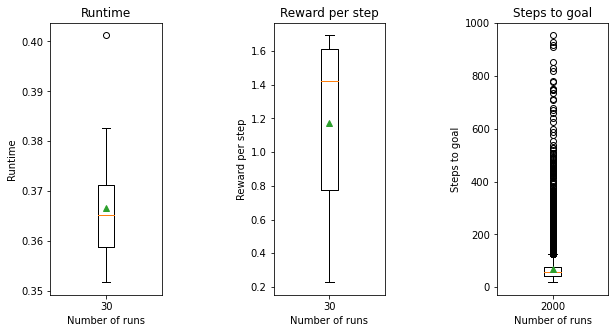

In [189]:
y = 0
x = 0
runs = 30
steps = 20000
random.seed(2)
runtime = []
rewardperstep = []
rewardmatrix = np.zeros((16,30))
matrixs = []
tests = [100, 200, 500, 600, 700, 800, 900, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]
g = Game()

for x in range(0,runs):
    start = timeit.default_timer()
    aux = 0
    g.e.matrix.fill(0)
    for y in range(0,steps):
        if y+1 in tests: #Running a test on the utility matrix and saving the current state
            stemp = g.r.state
            rtemp = g.r.reward
            sttemp = g.r.steps 
            g.r.reset()
            for z in range(0,999):
                g.walk(1,False,True,False)
            rewardmatrix[aux][x] = g.r.reward/1000
            aux +=1
            g.r.reward = rtemp
            g.r.steps  = sttemp
            g.r.state  = stemp
        else:
            g.walk(1,True,True,False)
    matrixs.append(g.e.matrix)
    g.r.reset()
    stop = timeit.default_timer()
    runtime.append(stop-start)
    
    
rewardperstep = rewardmatrix.mean(1)

#Showing Results    
print("Runtime stdev:",statistics.stdev(runtime))
print("Runtime mean:",statistics.mean(runtime))  

plt.plot(tests, rewardperstep,'ro')
plt.xlabel('Steps tested')
plt.ylabel('Average Rewards')

#Heatmap Geration
matrixfinal = np.mean(matrixs, axis=0)
matrixfinal[99]=100 
hmap = np.zeros((10,10))
count = 0
for a in range(10):
    for b in range(10):
        val = np.max(matrixfinal[count])
        hmap[a][b] = matrixfinal[count][np.argmax(matrixfinal[count])]
        count += 1
fig, ax = plt.subplots(figsize=(5,5))
img = ax.imshow(hmap,cmap ='hot')
cbar = fig.colorbar(img, ticks=[0, 100])
ax.set_title("Utility Matrix States | Greed = 0.3")

fig2,(ax2,ax3,ax4) = plt.subplots(1,3,figsize =(10, 5))
ax2.boxplot(runtime, positions=[30],showmeans=True)
ax2.set_title('Runtime')
ax2.set_xlabel('Number of runs')
ax2.set_ylabel('Runtime')
ax3.boxplot(rewardperstep,positions=[30],showmeans=True)
ax3.set_title('Reward per step')
ax3.set_xlabel('Number of runs')
ax3.set_ylabel('Reward per step')
ax4.boxplot(g.steps,positions=[2000],showmeans=True)
ax4.set_title('Steps to goal')
ax4.set_xlabel('Number of runs')
ax4.set_ylabel('Steps to goal')
fig2.subplots_adjust(wspace=1)

plt.show()

# EX 3 - Greed at 0.6

Runtime stdev: 0.013517839940596306
Runtime mean: 0.3694505000001906


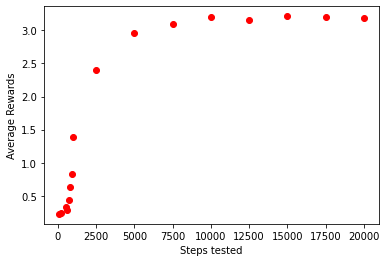

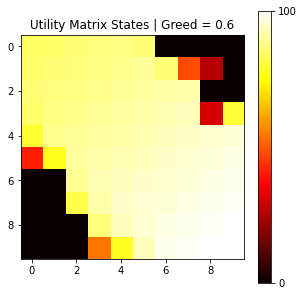

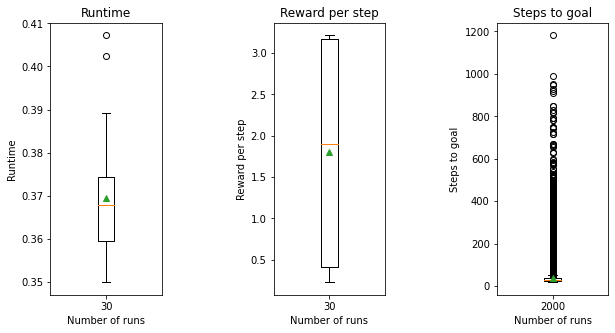

In [190]:
y = 0
x = 0
runs = 30
steps = 20000
random.seed(2)
runtime = []
rewardperstep = []
matrixs = []
rewardmatrix = np.zeros((16,30))
tests = [100, 200, 500, 600, 700, 800, 900, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]
g = Game()
g.prob[0] = 0.4
g.prob[1] = 0.6

for x in range(0,runs):
    start = timeit.default_timer()
    aux = 0
    g.e.matrix.fill(0)
    for y in range(0,steps):
        if y+1 in tests: #Running a test on the utility matrix and saving the current state
            stemp = g.r.state
            rtemp = g.r.reward
            sttemp = g.r.steps 
            g.r.reset()
            for z in range(0,999):
                g.walk(1,False,True,False)
            rewardmatrix[aux][x] = g.r.reward/1000
            aux +=1
            g.r.reward = rtemp
            g.r.steps  = sttemp
            g.r.state  = stemp
        else:
            g.walk(1,True,True,False)
    g.r.reset()
    matrixs.append(g.e.matrix)
    stop = timeit.default_timer()
    runtime.append(stop-start)
    
    
rewardperstep = rewardmatrix.mean(1)

#Showing Results    
print("Runtime stdev:",statistics.stdev(runtime))
print("Runtime mean:",statistics.mean(runtime))  

plt.plot(tests, rewardperstep,'ro')
plt.xlabel('Steps tested')
plt.ylabel('Average Rewards')

#Heatmap Geration
matrixfinal = np.mean(matrixs, axis=0)
matrixfinal[99]=100 
hmap = np.zeros((10,10))
count = 0
for a in range(10):
    for b in range(10):
        val = np.max(matrixfinal[count])
        hmap[a][b] = matrixfinal[count][np.argmax(matrixfinal[count])]
        count += 1
fig, ax = plt.subplots(figsize=(5,5))
img = ax.imshow(hmap,cmap ='hot')
cbar = fig.colorbar(img, ticks=[0, 100])
ax.set_title("Utility Matrix States | Greed = 0.6")

fig2,(ax2,ax3,ax4) = plt.subplots(1,3,figsize =(10, 5))
ax2.boxplot(runtime, positions=[30],showmeans=True)
ax2.set_title('Runtime')
ax2.set_xlabel('Number of runs')
ax2.set_ylabel('Runtime')
ax3.boxplot(rewardperstep,positions=[30],showmeans=True)
ax3.set_title('Reward per step')
ax3.set_xlabel('Number of runs')
ax3.set_ylabel('Reward per step')
ax4.boxplot(g.steps,positions=[2000],showmeans=True)
ax4.set_title('Steps to goal')
ax4.set_xlabel('Number of runs')
ax4.set_ylabel('Steps to goal')
fig2.subplots_adjust(wspace=1)

plt.show()

# EX 3 - Greed at 0.9

Runtime stdev: 0.011450401798181851
Runtime mean: 0.3550444833332828


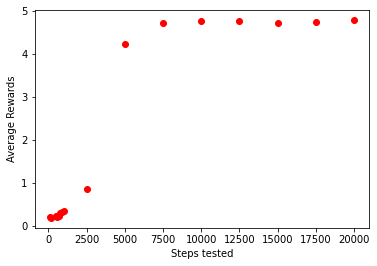

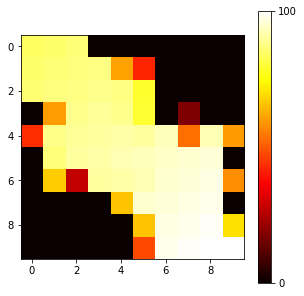

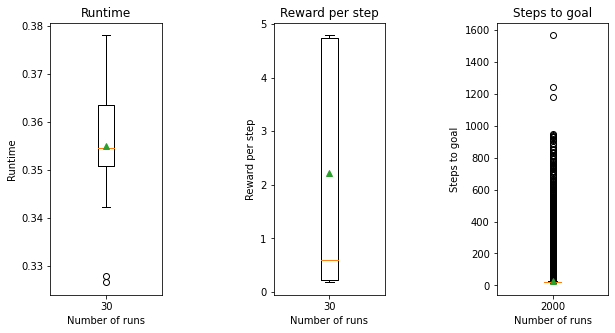

In [191]:
y = 0
x = 0
runs = 30
steps = 20000
random.seed(2)
runtime = []
rewardperstep = []
rewardmatrix = np.zeros((16,30))
matrixs = []
tests = [100, 200, 500, 600, 700, 800, 900, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]
g = Game()
g.prob[0] = 0.1
g.prob[1] = 0.9

for x in range(0,runs):
    start = timeit.default_timer()
    aux = 0
    g.e.matrix.fill(0)
    for y in range(0,steps):
        if y+1 in tests: #Running a test on the utility matrix and saving the current state
            stemp = g.r.state
            rtemp = g.r.reward
            sttemp = g.r.steps 
            g.r.reset()
            for z in range(0,999):
                g.walk(1,False,True,False)
            rewardmatrix[aux][x] = g.r.reward/1000
            aux +=1
            g.r.reward = rtemp
            g.r.steps  = sttemp
            g.r.state  = stemp
        else:
            g.walk(1,True,True,False)
    matrixs.append(g.e.matrix)
    g.r.reset()
    stop = timeit.default_timer()
    runtime.append(stop-start)
    
rewardperstep = rewardmatrix.mean(1)

#Showing Results    
print("Runtime stdev:",statistics.stdev(runtime))
print("Runtime mean:",statistics.mean(runtime))  

plt.plot(tests, rewardperstep,'ro')
plt.xlabel('Steps tested')
plt.ylabel('Average Rewards')

#Heatmap Geration
matrixfinal = np.mean(matrixs, axis=0)
matrixfinal[99]=100 
hmap = np.zeros((10,10))
count = 0
for a in range(10):
    for b in range(10):
        val = np.max(matrixfinal[count])
        hmap[a][b] = matrixfinal[count][np.argmax(matrixfinal[count])]
        count += 1
fig, ax = plt.subplots(figsize=(5,5))
img = ax.imshow(hmap,cmap ='hot')
cbar = fig.colorbar(img, ticks=[0, 100])
ax4.set_title("Utility Matrix States | Greed = 0.9")

fig2,(ax2,ax3,ax4) = plt.subplots(1,3,figsize =(10, 5))
ax2.boxplot(runtime, positions=[30],showmeans=True)
ax2.set_title('Runtime')
ax2.set_xlabel('Number of runs')
ax2.set_ylabel('Runtime')
ax3.boxplot(rewardperstep,positions=[30],showmeans=True)
ax3.set_title('Reward per step')
ax3.set_xlabel('Number of runs')
ax3.set_ylabel('Reward per step')
ax4.boxplot(g.steps,positions=[2000],showmeans=True)
ax4.set_title('Steps to goal')
ax4.set_xlabel('Number of runs')
ax4.set_ylabel('Steps to goal')
fig2.subplots_adjust(wspace=1)

plt.show()

# EX 3 - Increasing Greed


Its possible to view that different greed values affect the overall learning curve of the robot and only after reaching max levels of greed does the robot take always the shortest path to the reward

Runtime stdev: 0.011915513859464174
Runtime mean: 0.3764089466671673


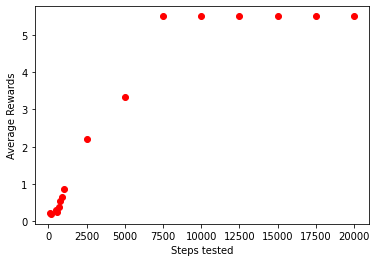

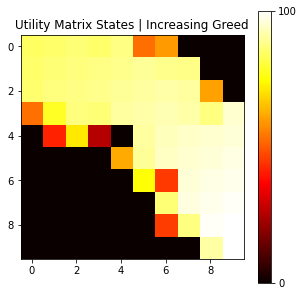

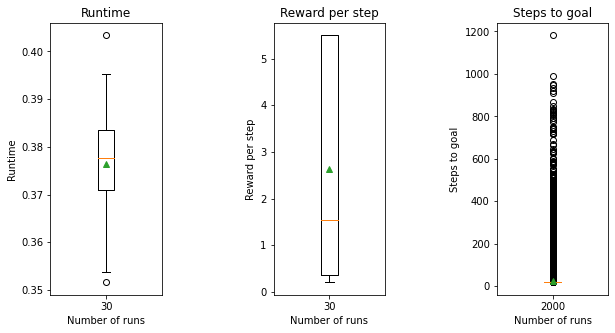

In [192]:
y = 0
x = 0
runs = 30
steps = 20000
random.seed(2)
runtime = []
rewardperstep = []
matrixs = []
rewardmatrix = np.zeros((16,30))
tests = [100, 200, 500, 600, 700, 800, 900, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]
g = Game()

for x in range(0,runs):
    start = timeit.default_timer()
    aux = 0
    g.e.matrix.fill(0)
    for y in range(0,steps):
        if(y >= steps*0.3 and g.prob[0] > 0 and g.prob[1] < 1 ): #Increasing probability
            g.prob[0] -= 0.01
            g.prob[1] += 0.01
        if y+1 in tests: #Running a test on the utility matrix and saving the current state
            stemp = g.r.state
            rtemp = g.r.reward
            sttemp = g.r.steps 
            g.r.reset()
            for z in range(0,999):
                g.walk(1,False,True,False)
            rewardmatrix[aux][x] = g.r.reward/1000
            aux +=1
            g.r.reward = rtemp
            g.r.steps  = sttemp
            g.r.state  = stemp
        else:
            g.walk(1,True,True,False)
    g.prob[0] = 0.3
    g.prob[1] = 0.7
    matrixs.append(g.e.matrix)
    g.r.reset()
    stop = timeit.default_timer()
    runtime.append(stop-start)
    
    
rewardperstep = rewardmatrix.mean(1)
    
#Showing Results    
print("Runtime stdev:",statistics.stdev(runtime))
print("Runtime mean:",statistics.mean(runtime))  

plt.plot(tests, rewardperstep,'ro')
plt.xlabel('Steps tested')
plt.ylabel('Average Rewards')

#Heatmap Geration
matrixfinal = np.mean(matrixs, axis=0)
matrixfinal[99]=100 
hmap = np.zeros((10,10))
count = 0
for a in range(10):
    for b in range(10):
        val = np.max(matrixfinal[count])
        hmap[a][b] = matrixfinal[count][np.argmax(matrixfinal[count])]
        count += 1
fig, ax = plt.subplots(figsize=(5,5))
img = ax.imshow(hmap,cmap ='hot')
cbar = fig.colorbar(img, ticks=[0, 100])
ax.set_title("Utility Matrix States | Increasing Greed")
    
fig2,(ax2,ax3,ax4) = plt.subplots(1,3,figsize =(10, 5))
ax2.boxplot(runtime, positions=[30],showmeans=True)
ax2.set_title('Runtime')
ax2.set_xlabel('Number of runs')
ax2.set_ylabel('Runtime')
ax3.boxplot(rewardperstep,positions=[30],showmeans=True)
ax3.set_title('Reward per step')
ax3.set_xlabel('Number of runs')
ax3.set_ylabel('Reward per step')
ax4.boxplot(g.steps,positions=[2000],showmeans=True)
ax4.set_title('Steps to goal')
ax4.set_xlabel('Number of runs')
ax4.set_ylabel('Steps to goal')
fig2.subplots_adjust(wspace=1)

plt.show()

# EX 4 (2a)

Used 100000 steps instead of 20000 steps so that the heatmap of the utility matrix can be better analysed 

Runtime stdev: 0.021819431369722996
Runtime mean: 0.8151445666665192


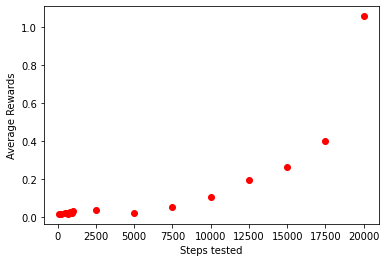

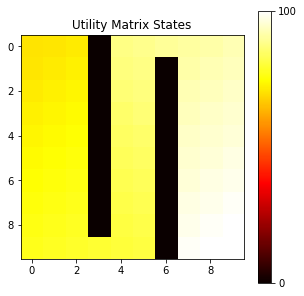

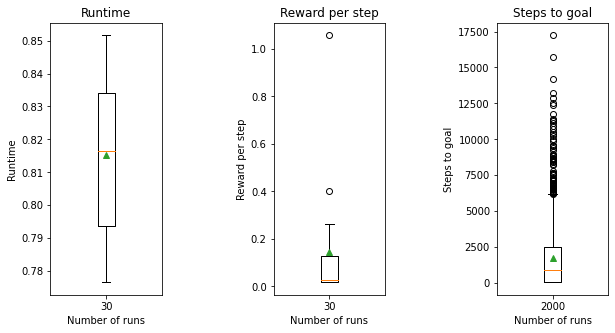

In [193]:
y = 0
x = 0
runs = 30
steps = 100000
random.seed(2)
runtime = []
reward = []
rewardmatrix = np.zeros((16,30))
matrixs = []
tests = [100, 200, 500, 600, 700, 800, 900, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]
g = Game()

for x in range(0,runs):
    start = timeit.default_timer()
    aux = 0
    g.e.matrix.fill(0)
    for y in range(0,steps):
        if y+1 in tests: #Running a test on the utility matrix and saving the current state
            stemp = g.r.state
            rtemp = g.r.reward
            sttemp = g.r.steps 
            g.r.reset()
            for z in range(0,999):
                g.walk(1,False,False,True)
            rewardmatrix[aux][x] = g.r.reward/1000
            aux +=1
            g.r.reward = rtemp
            g.r.steps  = sttemp
            g.r.state  = stemp
        else:
            g.walk(0,True,False,True)
    matrixs.append(g.e.matrix)
    g.r.reset()
    stop = timeit.default_timer()
    runtime.append(stop-start)
    
    
#Calculates the average reward per step for every test in all runs
rewardperstep = rewardmatrix.mean(1)

#Showing Results
print("Runtime stdev:",statistics.stdev(runtime))
print("Runtime mean:",statistics.mean(runtime))    

plt.plot(tests, rewardperstep,'ro')
plt.xlabel('Steps tested')
plt.ylabel('Average Rewards')

#Heatmap geration
matrixfinal = np.mean(matrixs, axis=0)
matrixfinal[99]=100 
hmap = np.zeros((10,10))
count = 0
for a in range(10):
    for b in range(10):
        val = np.max(matrixfinal[count])
        hmap[a][b] = matrixfinal[count][np.argmax(matrixfinal[count])]
        count += 1
fig, ax = plt.subplots(figsize=(5,5))
img = ax.imshow(hmap,cmap ='hot')
cbar = fig.colorbar(img, ticks=[0, 100])
ax.set_title("Utility Matrix States")
    
fig2,(ax2,ax3,ax4) = plt.subplots(1,3,figsize =(10, 5))
ax2.boxplot(runtime, positions=[30],showmeans=True)
ax2.set_title('Runtime')
ax2.set_xlabel('Number of runs')
ax2.set_ylabel('Runtime')
ax3.boxplot(rewardperstep,positions=[30],showmeans=True)
ax3.set_title('Reward per step')
ax3.set_xlabel('Number of runs')
ax3.set_ylabel('Reward per step')
ax4.boxplot(g.steps,positions=[2000],showmeans=True)
ax4.set_title('Steps to goal')
ax4.set_xlabel('Number of runs')
ax4.set_ylabel('Steps to goal')
fig2.subplots_adjust(wspace=1)

plt.show()

# EX 4 (2b)

Runtime stdev: 0.02438785551150323
Runtime mean: 1.149398423333696


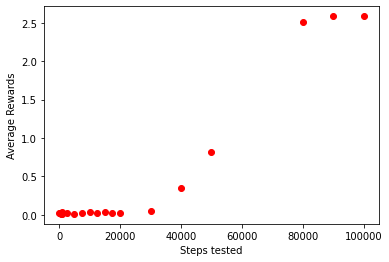

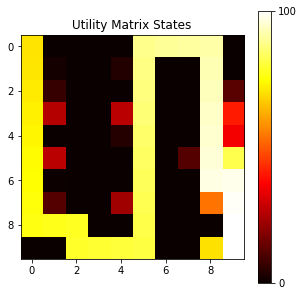

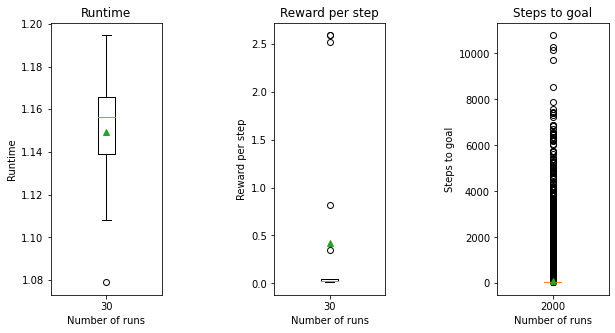

In [194]:
y = 0
x = 0
runs = 30
steps = 100000
random.seed(2)
runtime = []
reward = []
rewardmatrix = np.zeros((22,30))
matrixs = []
tests = [100, 200, 500, 600, 700, 800, 900, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000,30000,40000,50000,80000,90000,100000]
g = Game()

for x in range(0,runs):
    start = timeit.default_timer()
    aux = 0
    g.e.matrix.fill(0)
    for y in range(0,steps):
        if y+1 in tests: #Running a test on the utility matrix and saving the current state
            stemp = g.r.state
            rtemp = g.r.reward
            sttemp = g.r.steps 
            g.r.reset()
            for z in range(0,999):
                g.walk(1,False,False,True)
            rewardmatrix[aux][x] = g.r.reward/1000
            aux +=1
            g.r.reward = rtemp
            g.r.steps  = sttemp
            g.r.state  = stemp
        else:
            g.walk(1,True,False,True)
    matrixs.append(g.e.matrix)
    stop = timeit.default_timer()
    runtime.append(stop-start)
    g.r.reset()

 
 #Calculates the average reward per step for every test in all runs
rewardperstep = rewardmatrix.mean(1)

#Showing Results
print("Runtime stdev:",statistics.stdev(runtime))
print("Runtime mean:",statistics.mean(runtime))    

plt.plot(tests, rewardperstep,'ro')
plt.xlabel('Steps tested')
plt.ylabel('Average Rewards')

#Heatmap geration
matrixfinal = np.mean(matrixs, axis=0)
matrixfinal[99]=matrixfinal.max()
hmap = np.zeros((10,10))
count = 0
for a in range(10):
    for b in range(10):
        val = np.max(matrixfinal[count])
        hmap[a][b] = matrixfinal[count][np.argmax(matrixfinal[count])]
        count += 1
fig, ax = plt.subplots(figsize=(5,5))
img = ax.imshow(hmap,cmap ='hot')
cbar = fig.colorbar(img, ticks=[0, 100])
ax.set_title("Utility Matrix States")
    
fig2,(ax2,ax3,ax4) = plt.subplots(1,3,figsize =(10, 5))
ax2.boxplot(runtime, positions=[30],showmeans=True)
ax2.set_title('Runtime')
ax2.set_xlabel('Number of runs')
ax2.set_ylabel('Runtime')
ax3.boxplot(rewardperstep,positions=[30],showmeans=True)
ax3.set_title('Reward per step')
ax3.set_xlabel('Number of runs')
ax3.set_ylabel('Reward per step')
ax4.boxplot(g.steps,positions=[2000],showmeans=True)
ax4.set_title('Steps to goal')
ax4.set_xlabel('Number of runs')
ax4.set_ylabel('Steps to goal')
fig2.subplots_adjust(wspace=1)

plt.show()

# EX 4 (3 Greed = 0.3)

Runtime stdev: 0.04142029189951438
Runtime mean: 1.1883339633336922


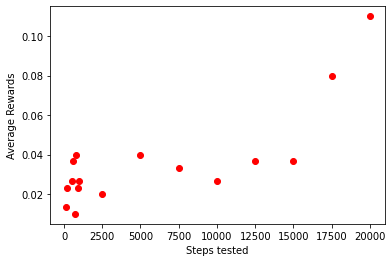

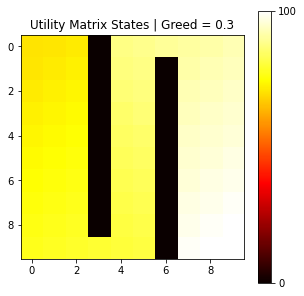

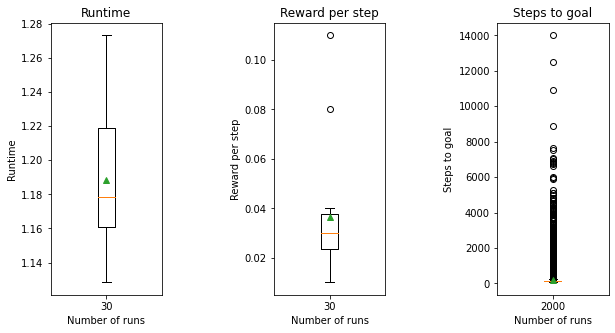

In [195]:
y = 0
x = 0
runs = 30
steps = 100000
random.seed(2)
runtime = []
rewardperstep = []
rewardmatrix = np.zeros((16,30))
matrixs = []
tests = [100, 200, 500, 600, 700, 800, 900, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]
g = Game()

for x in range(0,runs):
    start = timeit.default_timer()
    aux = 0
    g.e.matrix.fill(0)
    for y in range(0,steps):
        if y+1 in tests: #Running a test on the utility matrix and saving the current state
            stemp = g.r.state
            rtemp = g.r.reward
            sttemp = g.r.steps 
            g.r.reset()
            for z in range(0,999):
                g.walk(1,False,True,True)
            rewardmatrix[aux][x] = g.r.reward/1000
            aux +=1
            g.r.reward = rtemp
            g.r.steps  = sttemp
            g.r.state  = stemp
        else:
            g.walk(1,True,True,True)
    matrixs.append(g.e.matrix)
    g.r.reset()
    stop = timeit.default_timer()
    runtime.append(stop-start)
    
    
rewardperstep = rewardmatrix.mean(1)

#Showing Results    
print("Runtime stdev:",statistics.stdev(runtime))
print("Runtime mean:",statistics.mean(runtime))  

plt.plot(tests, rewardperstep,'ro')
plt.xlabel('Steps tested')
plt.ylabel('Average Rewards')

#Heatmap Geration
matrixfinal = np.mean(matrixs, axis=0)
matrixfinal[99]=100 
hmap = np.zeros((10,10))
count = 0
for a in range(10):
    for b in range(10):
        val = np.max(matrixfinal[count])
        hmap[a][b] = matrixfinal[count][np.argmax(matrixfinal[count])]
        count += 1
fig, ax = plt.subplots(figsize=(5,5))
img = ax.imshow(hmap,cmap ='hot')
cbar = fig.colorbar(img, ticks=[0, 100])
ax.set_title("Utility Matrix States | Greed = 0.3")

fig2,(ax2,ax3,ax4) = plt.subplots(1,3,figsize =(10, 5))
ax2.boxplot(runtime, positions=[30],showmeans=True)
ax2.set_title('Runtime')
ax2.set_xlabel('Number of runs')
ax2.set_ylabel('Runtime')
ax3.boxplot(rewardperstep,positions=[30],showmeans=True)
ax3.set_title('Reward per step')
ax3.set_xlabel('Number of runs')
ax3.set_ylabel('Reward per step')
ax4.boxplot(g.steps,positions=[2000],showmeans=True)
ax4.set_title('Steps to goal')
ax4.set_xlabel('Number of runs')
ax4.set_ylabel('Steps to goal')
fig2.subplots_adjust(wspace=1)

plt.show()

# EX 4 (3 Greed = 0.6)

Runtime stdev: 0.03266445628283826
Runtime mean: 1.241308343333003


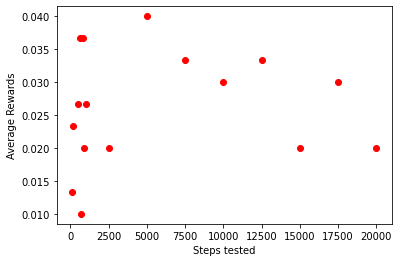

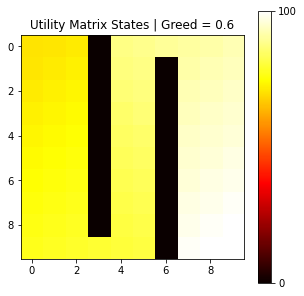

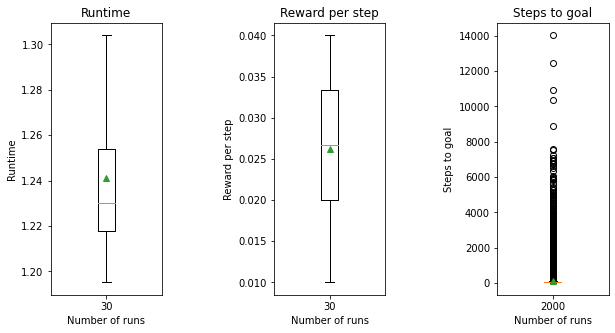

In [196]:
y = 0
x = 0
runs = 30
steps = 100000
random.seed(2)
runtime = []
rewardperstep = []
matrixs = []
rewardmatrix = np.zeros((16,30))
tests = [100, 200, 500, 600, 700, 800, 900, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]
g = Game()
g.prob[0] = 0.4
g.prob[1] = 0.6

for x in range(0,runs):
    start = timeit.default_timer()
    aux = 0
    g.e.matrix.fill(0)
    for y in range(0,steps):
        if y+1 in tests: #Running a test on the utility matrix and saving the current state
            stemp = g.r.state
            rtemp = g.r.reward
            sttemp = g.r.steps 
            g.r.reset()
            for z in range(0,999):
                g.walk(1,False,True,True)
            rewardmatrix[aux][x] = g.r.reward/1000
            aux +=1
            g.r.reward = rtemp
            g.r.steps  = sttemp
            g.r.state  = stemp
        else:
            g.walk(1,True,True,True)
    g.r.reset()
    matrixs.append(g.e.matrix)
    stop = timeit.default_timer()
    runtime.append(stop-start)
    
    
rewardperstep = rewardmatrix.mean(1)

#Showing Results    
print("Runtime stdev:",statistics.stdev(runtime))
print("Runtime mean:",statistics.mean(runtime))  

plt.plot(tests, rewardperstep,'ro')
plt.xlabel('Steps tested')
plt.ylabel('Average Rewards')

#Heatmap Geration
matrixfinal = np.mean(matrixs, axis=0)
matrixfinal[99]=100 
hmap = np.zeros((10,10))
count = 0
for a in range(10):
    for b in range(10):
        val = np.max(matrixfinal[count])
        hmap[a][b] = matrixfinal[count][np.argmax(matrixfinal[count])]
        count += 1
fig, ax = plt.subplots(figsize=(5,5))
img = ax.imshow(hmap,cmap ='hot')
cbar = fig.colorbar(img, ticks=[0, 100])
ax.set_title("Utility Matrix States | Greed = 0.6")

fig2,(ax2,ax3,ax4) = plt.subplots(1,3,figsize =(10, 5))
ax2.boxplot(runtime, positions=[30],showmeans=True)
ax2.set_title('Runtime')
ax2.set_xlabel('Number of runs')
ax2.set_ylabel('Runtime')
ax3.boxplot(rewardperstep,positions=[30],showmeans=True)
ax3.set_title('Reward per step')
ax3.set_xlabel('Number of runs')
ax3.set_ylabel('Reward per step')
ax4.boxplot(g.steps,positions=[2000],showmeans=True)
ax4.set_title('Steps to goal')
ax4.set_xlabel('Number of runs')
ax4.set_ylabel('Steps to goal')
fig2.subplots_adjust(wspace=1)

plt.show()

# EX 4 (3 Greed = 0.9)

Runtime stdev: 0.040889852010433665
Runtime mean: 1.2912733400002858


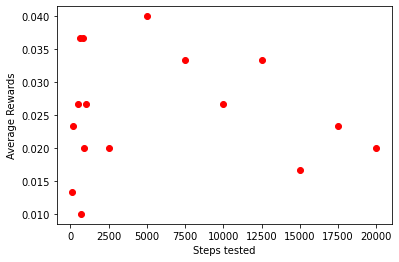

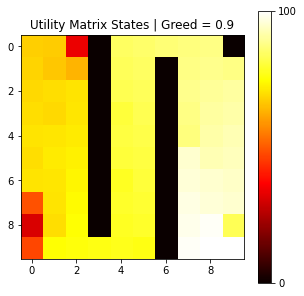

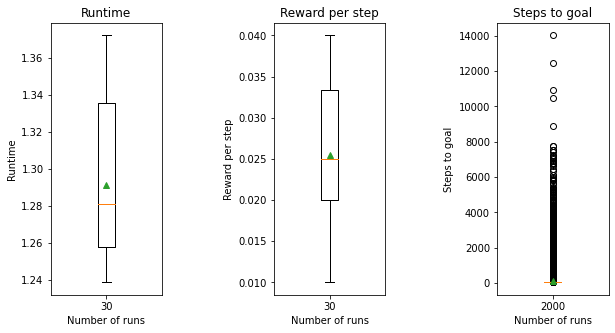

In [197]:
y = 0
x = 0
runs = 30
steps = 100000
random.seed(2)
runtime = []
rewardperstep = []
rewardmatrix = np.zeros((16,30))
matrixs = []
tests = [100, 200, 500, 600, 700, 800, 900, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]
g = Game()
g.prob[0] = 0.1
g.prob[1] = 0.9

for x in range(0,runs):
    start = timeit.default_timer()
    aux = 0
    g.e.matrix.fill(0)
    for y in range(0,steps):
        if y+1 in tests: #Running a test on the utility matrix and saving the current state
            stemp = g.r.state
            rtemp = g.r.reward
            sttemp = g.r.steps 
            g.r.reset()
            for z in range(0,999):
                g.walk(1,False,True,True)
            rewardmatrix[aux][x] = g.r.reward/1000
            aux +=1
            g.r.reward = rtemp
            g.r.steps  = sttemp
            g.r.state  = stemp
        else:
            g.walk(1,True,True,True)
    matrixs.append(g.e.matrix)
    g.r.reset()
    stop = timeit.default_timer()
    runtime.append(stop-start)
    
rewardperstep = rewardmatrix.mean(1)

#Showing Results    
print("Runtime stdev:",statistics.stdev(runtime))
print("Runtime mean:",statistics.mean(runtime))  

plt.plot(tests, rewardperstep,'ro')
plt.xlabel('Steps tested')
plt.ylabel('Average Rewards')

#Heatmap Geration
matrixfinal = np.mean(matrixs, axis=0)
matrixfinal[99]=100 
hmap = np.zeros((10,10))
count = 0
for a in range(10):
    for b in range(10):
        val = np.max(matrixfinal[count])
        hmap[a][b] = matrixfinal[count][np.argmax(matrixfinal[count])]
        count += 1
fig, ax = plt.subplots(figsize=(5,5))
img = ax.imshow(hmap,cmap ='hot')
cbar = fig.colorbar(img, ticks=[0, 100])
ax.set_title("Utility Matrix States | Greed = 0.9")

fig2,(ax2,ax3,ax4) = plt.subplots(1,3,figsize =(10, 5))
ax2.boxplot(runtime, positions=[30],showmeans=True)
ax2.set_title('Runtime')
ax2.set_xlabel('Number of runs')
ax2.set_ylabel('Runtime')
ax3.boxplot(rewardperstep,positions=[30],showmeans=True)
ax3.set_title('Reward per step')
ax3.set_xlabel('Number of runs')
ax3.set_ylabel('Reward per step')
ax4.boxplot(g.steps,positions=[2000],showmeans=True)
ax4.set_title('Steps to goal')
ax4.set_xlabel('Number of runs')
ax4.set_ylabel('Steps to goal')
fig2.subplots_adjust(wspace=1)

plt.show()

# EX 4 (3 Greed increasing)

Runtime stdev: 0.048430482322399895
Runtime mean: 1.3620383000002525


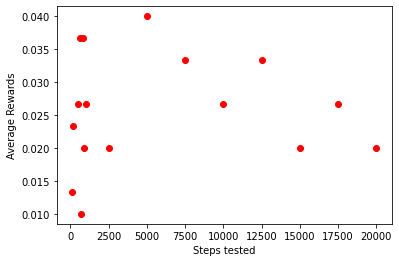

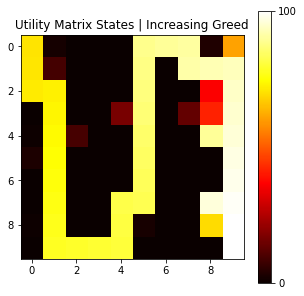

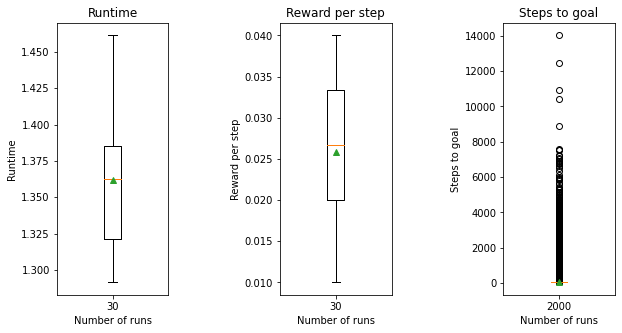

In [198]:
y = 0
x = 0
runs = 30
steps = 100000
random.seed(2)
runtime = []
rewardperstep = []
matrixs = []
rewardmatrix = np.zeros((16,30))
tests = [100, 200, 500, 600, 700, 800, 900, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]
g = Game()

for x in range(0,runs):
    start = timeit.default_timer()
    aux = 0
    g.e.matrix.fill(0)
    for y in range(0,steps):
        if(y >= steps*0.3 and g.prob[0] > 0 and g.prob[1] < 1 ): #Increasing probability
            g.prob[0] -= 0.01
            g.prob[1] += 0.01
        if y+1 in tests: #Running a test on the utility matrix and saving the current state
            stemp = g.r.state
            rtemp = g.r.reward
            sttemp = g.r.steps 
            g.r.reset()
            for z in range(0,999):
                g.walk(1,False,True,True)
            rewardmatrix[aux][x] = g.r.reward/1000
            aux +=1
            g.r.reward = rtemp
            g.r.steps  = sttemp
            g.r.state  = stemp
        else:
            g.walk(1,True,True,True)
    g.prob[0] = 0.3
    g.prob[1] = 0.7
    matrixs.append(g.e.matrix)
    g.r.reset()
    stop = timeit.default_timer()
    runtime.append(stop-start)
    
    
rewardperstep = rewardmatrix.mean(1)
    
#Showing Results    
print("Runtime stdev:",statistics.stdev(runtime))
print("Runtime mean:",statistics.mean(runtime))  

plt.plot(tests, rewardperstep,'ro')
plt.xlabel('Steps tested')
plt.ylabel('Average Rewards')

#Heatmap Geration
matrixfinal = np.mean(matrixs, axis=0)
matrixfinal[99]=100 
hmap = np.zeros((10,10))
count = 0
for a in range(10):
    for b in range(10):
        val = np.max(matrixfinal[count])
        hmap[a][b] = matrixfinal[count][np.argmax(matrixfinal[count])]
        count += 1
fig, ax = plt.subplots(figsize=(5,5))
img = ax.imshow(hmap,cmap ='hot')
cbar = fig.colorbar(img, ticks=[0, 100])
ax.set_title("Utility Matrix States | Increasing Greed")
    
fig2,(ax2,ax3,ax4) = plt.subplots(1,3,figsize =(10, 5))
ax2.boxplot(runtime, positions=[30],showmeans=True)
ax2.set_title('Runtime')
ax2.set_xlabel('Number of runs')
ax2.set_ylabel('Runtime')
ax3.boxplot(rewardperstep,positions=[30],showmeans=True)
ax3.set_title('Reward per step')
ax3.set_xlabel('Number of runs')
ax3.set_ylabel('Reward per step')
ax4.boxplot(g.steps,positions=[2000],showmeans=True)
ax4.set_title('Steps to goal')
ax4.set_xlabel('Number of runs')
ax4.set_ylabel('Steps to goal')
fig2.subplots_adjust(wspace=1)

plt.show()

Its visible that walls affect the learning process of the robot making it harder for it 